In [113]:
import numpy as np
import pandas as pd
import seaborn
from copy import deepcopy
from tqdm import tqdm_notebook, tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib
import json

from experiments.libs.loaders import load_bci
from experiments.libs.timer import Timer

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

In [7]:
pipeline_steps = [('scale', StandardScaler())]
continuous_pipeline = Pipeline(steps=pipeline_steps)

In [8]:
featurisers = [('continuous', continuous_pipeline)]

In [9]:
xgb_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', XGBClassifier(max_depth=3, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                gamma=0.1,
                                                                subsample=1))])

In [10]:
lgbm_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', LGBMClassifier(num_leaves=2**3, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                subsample=1))])

In [13]:
%%time
X, y, X_test, y_test = load_bci()

CPU times: user 2.35 s, sys: 396 ms, total: 2.75 s
Wall time: 23.5 s


In [51]:
metrics_dict = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'AUC': roc_auc_score,
    'F1': f1_score,
}

def classification_metrics(metrics, y_true, y_pred):
    return {metric_name:metric(y_true, y_pred) for metric_name, metric in metrics.items()}

In [16]:
results_dict = dict()

In [54]:
with Timer() as t:
    xgb_clf_pipeline.fit(np.concatenate(X),np.concatenate(y))
    y_pred = xgb_clf_pipeline.predict(np.concatenate(X_test))

In [55]:
results_dict['xgb']={
    'time': t.interval,
    'performance': classification_metrics(metrics_dict, 
                                          np.concatenate(y_test), 
                                          y_pred) 
}

In [48]:
with Timer() as t:
    lgbm_clf_pipeline.fit(np.concatenate(X),np.concatenate(y))
    y_pred = lgbm_clf_pipeline.predict(np.concatenate(X_test))

In [52]:
results_dict['lgbm']={
    'time': t.interval,
    'performance': classification_metrics(metrics_dict, 
                                          np.concatenate(y_test), 
                                          y_pred) 
}

In [58]:
print(json.dumps(results_dict, indent=4, sort_keys=True))

{
    "lgbm": {
        "performance": {
            "AUC": 0.5318846153846153,
            "Accuracy": 0.8812311809969889,
            "F1": 0.12561576354679804,
            "Precision": 0.6071428571428571,
            "Recall": 0.07005494505494506
        },
        "time": 46.56049299999995
    },
    "xgb": {
        "performance": {
            "AUC": 0.5277435897435897,
            "Accuracy": 0.8812311809969889,
            "F1": 0.11027568922305765,
            "Precision": 0.6285714285714286,
            "Recall": 0.06043956043956044
        },
        "time": 200.86333100000002
    }
}


In [59]:
def run_train_retrain_comparison(model, X, y, X_test, y_test):
    retrain_model = deepcopy(model)
    historical_X = deepcopy(X.tolist())
    historical_y = deepcopy(y.tolist())
    train_auc=[]
    retrain_auc=[]
    for X_test_run, y_test_run in  tqdm_notebook(zip(X_test, y_test), total=len(y_test)):
        prev_model = deepcopy(retrain_model)
        
        y_pred = model.predict_proba(X_test_run)
        train_auc.append(roc_auc_score(y_test_run, y_pred[:, 1]))

        y_pred = retrain_model.predict_proba(X_test_run)
        retrain_auc.append(roc_auc_score(y_test_run, y_pred[:, 1]))

        historical_X.append(X_test_run)
        historical_y.append(y_test_run)

        new_train_X  = np.concatenate(historical_X)
        retrain_model.fit(new_train_X, np.concatenate(historical_y))
        
    return pd.DataFrame({
        'Train AUC':train_auc,
        'Retrain AUC':retrain_auc
    })

In [114]:
with Timer() as t:
    df = run_train_retrain_comparison(xgb_clf_pipeline, X, y, X_test, y_test)

In [117]:
retrain_results_dict=dict()

In [118]:
retrain_results_dict['xgb']={
    'time': t.interval,
    'results': df
}

In [119]:
with Timer() as t:
    df = run_train_retrain_comparison(lgbm_clf_pipeline, X, y, X_test, y_test)

In [121]:
retrain_results_dict['lgbm']={
    'time': t.interval,
    'results': df
}

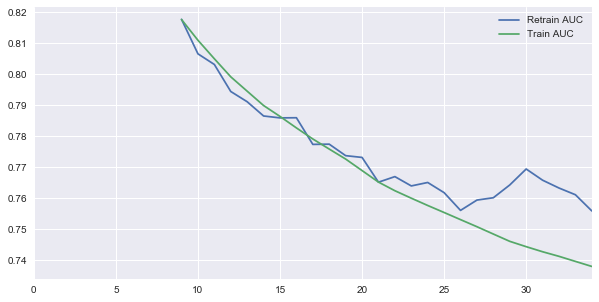

In [150]:
# XGB Retrain Results
retrain_results_dict['xgb']['results'].rolling(window=10).mean().plot();

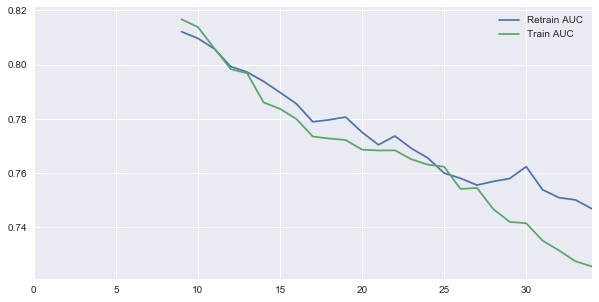

In [151]:
# LGBM Retrain Results
retrain_results_dict['lgbm']['results'].rolling(window=10).mean().plot();

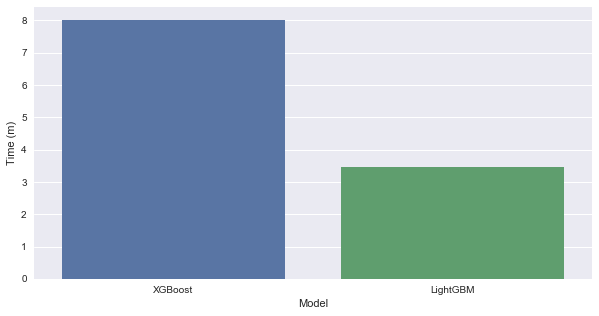

In [156]:
# XGB vs LGBM Retrain Time
t_res = pd.DataFrame([['XGBoost', retrain_results_dict['xgb']['time']/60],
              ['LightGBM', retrain_results_dict['lgbm']['time']/60]], columns=['Model', 'Time(m)'])
ax = seaborn.barplot(x="Model", y="Time(m)", data=t_res)
ax.set(ylabel='Time (m)');